This is the 2nd notebook for the walkthrough of `DGL` library. In this notebook, we are going to build machine learning models that learn from graph for graph classification.  

## 1. Tutorial: Batched graph classification with DGL

First going throgh the [offical tutorial](https://docs.dgl.ai/tutorials/basics/4_batch.html#). This tutorial can help to learn how to use DGL to batch multiple graphs of variabe size and shape as well as train a graph neural network for a simple graph classifcaiton task.

### 1.1. Goal: Classify types of topologies

The dataset we use has eight different types of graphs and each class has the smae numer of graph samples.

    * class 0 : cycle graph
    * class 1 : star graph
    * class 2 : wheel graph
    * class 3 : lollipop graph
    * class 4 : hypercube graph
    * class 5 : grid graph
    * class 6 : clique graph
    * class 7 : circular ladder graph

In [15]:
import dgl
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx

Now, let's build a dataset with 80 graph samples. The number of nodes for each graph is from 10 to 20.

In [2]:
dataset = MiniGCDataset(80,10,20)

In [14]:
graph, label = dataset[0]
print(f'The graph of first sample:\n{graph}')
print(f'The label of first sample: {label}')

The graph of first sample:
DGLGraph(num_nodes=13, num_edges=39,
         ndata_schemes={}
         edata_schemes={})
The label of first sample: 0


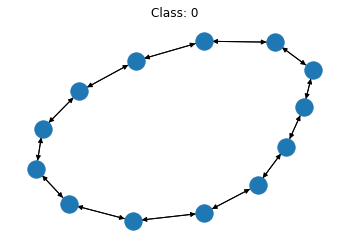

In [20]:
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title(f'Class: {label}')
plt.show()

### 1.2. Form a graph mini-batch

To train neural network effciently, a common practice isto batch multiple samples together to form a mini-batch. Batching fixed-shaped tensor inputs is common. For example, batching two images of size 28 * 28 gives a tensor of shape 2 * 28 * 28. By contrast, batching graph inputs has two challenges:
 - Graphs are sparse
 - Graphs can have various length (different numbers of nodes and edges)
 
To address this, DGL provides a `dgl.batch()` API. It leverages the idea that a batch of graphs can be viewed as **a large graph that has many disjointed connected components**. 

Denfine the following `collate` function to form a mini-batch from a given list of graph and label pairs. The input `samples` is a list of tuple pairs *(graph, label)*.

In [16]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

The return type of `dgl.batch()` is still a graph. In the same way, a batch of tensors is still a tensor. This means that any code that works for one graph immediately works for a batch of graphs. More importantly, because DGL processes messages on all nodes and edges in parallel, this greatly improves efficiency.

### 1.3. Graph classifier

There are three process in a graph classification model:
 - Graph convolution: encoding local graph and updating node features
 - Graph readout: extracting graph level representation
 - Make predictions, e.g., softmax.

In [26]:
import dgl.function as fn
import torch
import torch.nn as nn

# sends a message of node feature h.
msg = fn.copy_src(src = 'h', out = 'm')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

In [24]:
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

In [27]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.1059
Epoch 1, loss 1.9146
Epoch 2, loss 1.8838
Epoch 3, loss 1.7773
Epoch 4, loss 1.6982
Epoch 5, loss 1.6100
Epoch 6, loss 1.5103
Epoch 7, loss 1.4288
Epoch 8, loss 1.3748
Epoch 9, loss 1.2947
Epoch 10, loss 1.2358
Epoch 11, loss 1.2205
Epoch 12, loss 1.1772
Epoch 13, loss 1.0948
Epoch 14, loss 1.0836
Epoch 15, loss 1.0764
Epoch 16, loss 1.0159
Epoch 17, loss 0.9840
Epoch 18, loss 0.9874
Epoch 19, loss 0.9871
Epoch 20, loss 0.9559
Epoch 21, loss 0.9518
Epoch 22, loss 0.9342
Epoch 23, loss 0.9051
Epoch 24, loss 0.8852
Epoch 25, loss 0.8902
Epoch 26, loss 0.8555
Epoch 27, loss 0.8733
Epoch 28, loss 0.8496
Epoch 29, loss 0.8225
Epoch 30, loss 0.8176
Epoch 31, loss 0.8274
Epoch 32, loss 0.7980
Epoch 33, loss 0.7832
Epoch 34, loss 0.7947
Epoch 35, loss 0.8108
Epoch 36, loss 0.7859
Epoch 37, loss 0.7849
Epoch 38, loss 0.7516
Epoch 39, loss 0.7748
Epoch 40, loss 0.7728
Epoch 41, loss 0.7342
Epoch 42, loss 0.7118
Epoch 43, loss 0.7064
Epoch 44, loss 0.7198
Epoch 45, loss 0.698

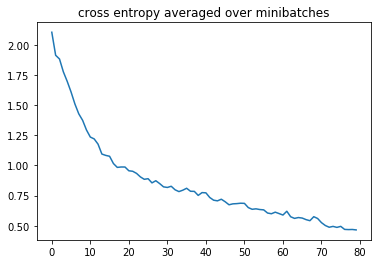

In [28]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

In [29]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 73.7500%
Accuracy of argmax predictions on the test set: 93.750000%


In summary, when setting up the training process, we need:
 - 1. Create the training and test sets (a `class`)
 - 2. Use pytorch's `Dataloader` and the defined `collate` function.
 - 3. Define the classifier.
 - 4. define loss function.
 - 5. define optimizer
 - 6. set to `model.train()` mode.
 

## 2. Model Overview 

This is a walk through of the [offical tutorial](https://docs.dgl.ai/tutorials/models/index.html). `DGL` is designed for a broad range of applications. It aims to build *state-of-the-art* models out-of-the-box.


### 2.1. Graph Convolutional Network



## 2. Predicting Molecular Activity

**Cheminformatics** is the scientific field that develops and applies computational methods to solve chemical problems. It aims at helping chemists in investigating and understanding complex chemical biological systems and guide the experimental design and decision making. It has been applied in a wide range of case studies such as discovering novel molecules/materials with desired activities/properties, virtually screening of large chemical databases and
predicting the outcomes of chemical reactions.

One of the primary tasks of cheminformatics is to predict the physical, chemical and biological properties of a given compound. **Quantitative Structure-Property/Activity Relationship (QSPR/QSAR)** modeling relies on machine learning techniques to establish quantified links between `molecular structures` and their `experimental properties/activities`.

Typical QSAR tasks are regression and classification. The regression models predict a numerical value, such as he kinase inhibition potency of a given compound. The classification models predict a category, such as a given compound is considered as toxic or not.

### Classification Models on Tox21 Dataset